In [1]:
# Import functions
import numpy as np
from tclab import TCLab, clock, Historian, Plotter, setup
import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import os
from tqdm import tqdm  
import random
from scipy.signal import cont2discrete
from collections import deque
from scipy.optimize import differential_evolution

# 1. Data Collection

Author: Carl Knable

In this section we define the functions that we will use to collect data from the TC-Lab. The main data-collection function is then run and plotted.

### Definition and Collection

In [30]:
# Heater function definitions
def sine_wave(t, period=4*60, amplitude=50, offset=50):
    """ Generate a sine wave with the given parameters.

    Arguments:
    t:          time (seconds)
    period:     period of the sine wave (seconds)
    amplitude:  amplitude of the sine wave
    offset:     offset of the sine wave
    
    """
    return amplitude * np.sin(2 * np.pi * t / period) + offset

def cosine_wave(t, period=4*60, amplitude=50, offset=50):
    """ Generate a sine wave with the given parameters.

    Arguments:
    t:          time (seconds)
    period:     period of the sine wave (seconds)
    amplitude:  amplitude of the sine wave
    offset:     offset of the sine wave
    
    """
    return -amplitude * np.sin(2 * np.pi * t / period) + offset

def ramp(t):
    """ Generate a linear increase and decrease twice from 0-100.

    Arguments:
    t: time (seconds)
    
    """
    if t<300:
        return(t/3)
    elif t<600:
        return(100-(t-300)/3)
    elif t<900:
        return((t-600)/3)
    else:
        return(100-(t-900)/3)
    
def step(t):
     """ Generate a step increase and decrease twice from 0-100.

    Arguments:
    t: time (seconds)
    
    """
    if t<300:
        return(100)
    elif t<600:
        return(0)
    elif t<900:
        return(100)
    else:
        return(0)

def heat(t):
    """ Return a constant value of 70.
    
    Arguments:
    t: time (seconds)
    
    """
    return(70)

def cool(t):
    """ Return a constant value of 100 for 300 seconds, then 0.
    
    Arguments:
    t: time (seconds)
    
    """
    if t<300:
        return(100)
    else:
        return(0)

def long_cool(t):
    """ Return a constant value of 100 for 300 seconds, and then linearly decrease.
    
    Arguments:
    t: time (seconds)
    
    """
    if t<300:
        return(100)
    else:
        return(100-(t-300)/9)

def zero(t):
    """ Return a constant value of 0.
    
    Arguments:
    t: time (seconds)
    
    """
    return(0)

In [31]:
# Overnight data collection function definition
def Data_Collection(Night_Number):
    # Define variables
    functions = [sine_wave, cosine_wave, ramp, step, heat, cool, long_cool, zero]
    f_names = ['sine', 'cosine', 'ramp', 'step', 'heat', 'cool', 'long_cool', 'zero']
    TCLab = setup(connected = True) # TEST (connected=False, speedup = 10)
    run_tclab = True

    # Define range for a given run
    range_start = 0
    range_end = 2
        
    if Night_Number == 2:
        range_start += 2
        range_end += 2
    elif Night_Number == 3:
        range_start += 4
        range_end += 4
    elif Night_Number == 4:
        range_start += 6
        range_end += 6
    
    # Loop through functions in run
    for i in range(range_start,range_end):
        for j in range(len(functions)):
            if run_tclab:
        
                # experimental parameters
                tfinal = 1200
            
                # perform experiment
                with TCLab() as lab:
                    lab.P1 = 200
                    lab.U1 = 50 # this is not needed because we will reset it in the loop
                    lab.U2 = 0
                    h = Historian(lab.sources)
                    p = Plotter(h, tfinal)
                    for t in clock(tfinal):
                        # Set lab.U1 and lab.U2 to the appropriate function
                        lab.U1 = functions[j](t)
                        lab.U2 = functions[i](t)
                        
                        p.update(t)
            
            # Filename
            data_file = f_names[j]+'_'+f_names[i]+'.csv'
            
            if run_tclab:
            
                # Set to True to overwrite the file. Default is False
                # to safeguard against accidentally rerunning this cell.
                overwrite_file = True
            
                if not overwrite_file and os.path.isfile('./'+data_file):
                    raise FileExistsError(data_file + ' already exisits. Either choose a new filename or set overwrite_file = True.')
                elif run_tclab:
                    h.to_csv(data_file)
                    print("Successfully saved data to "+data_file)
                else:
                    print("Data was not saved because run_tclab = False")
        
            time.sleep(10 * 60)  # Waits for 10 minutes (600 seconds)

    

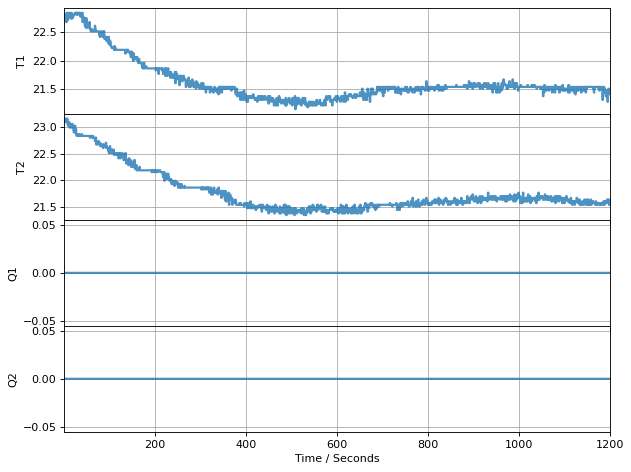

TCLab disconnected successfully.
Successfully saved data to zero_zero.csv


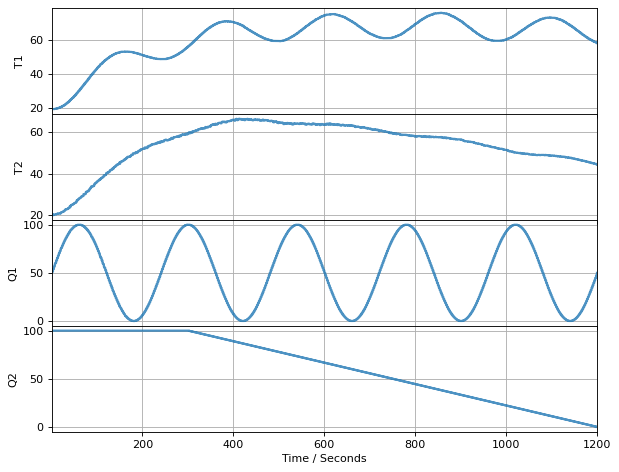

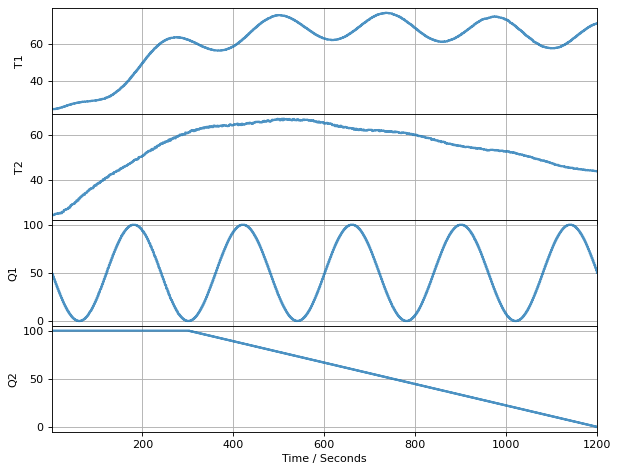

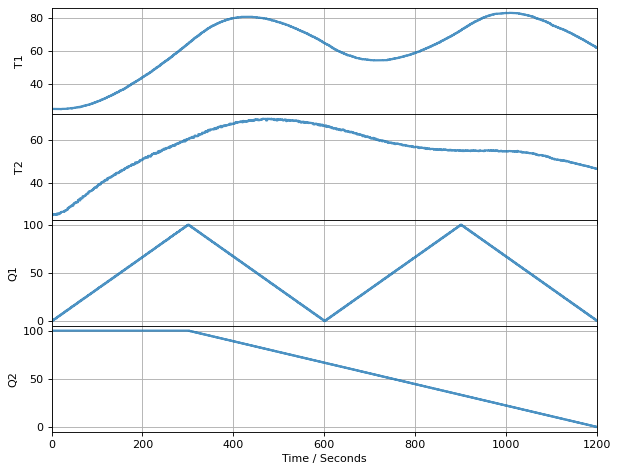

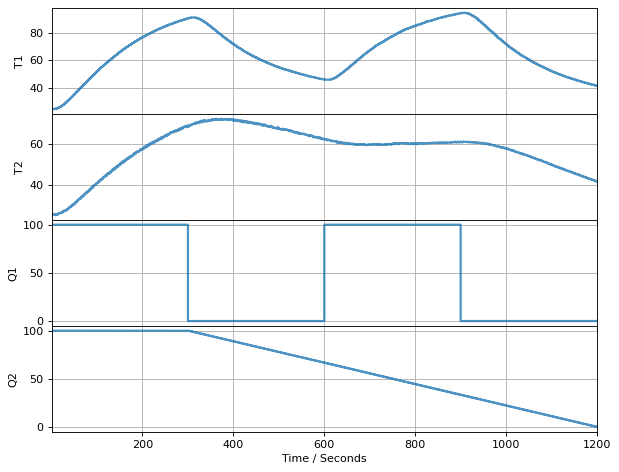

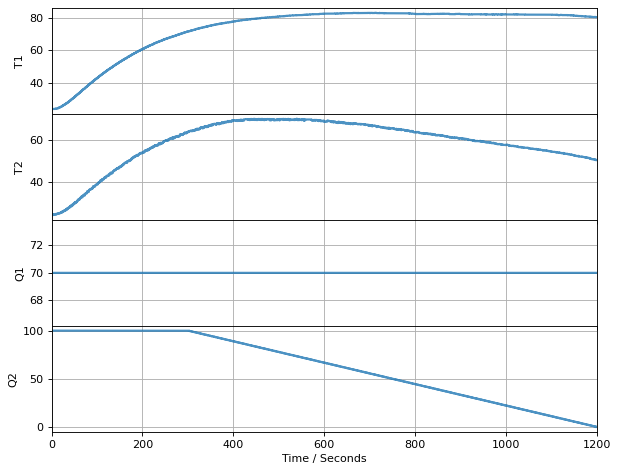

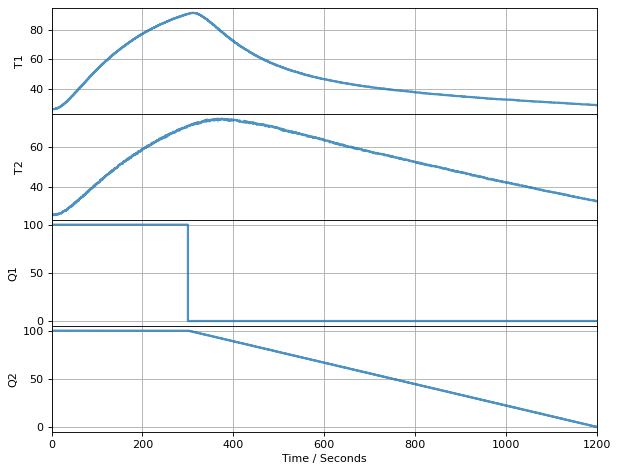

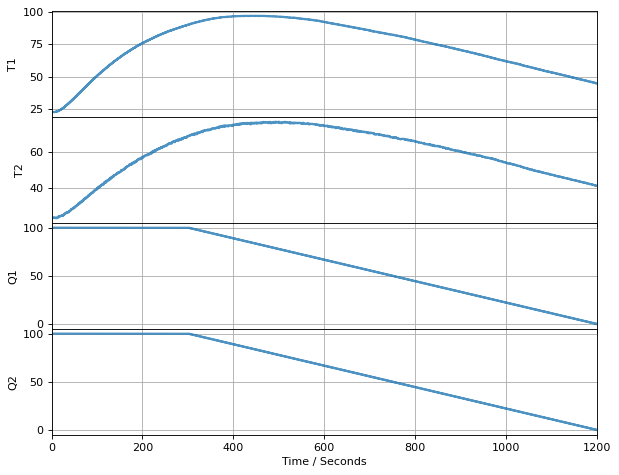

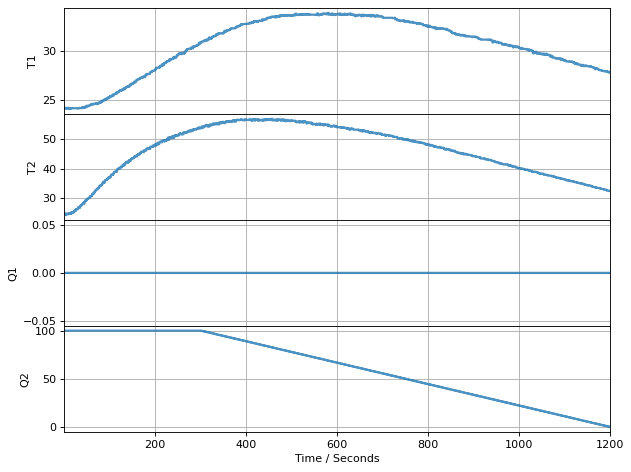

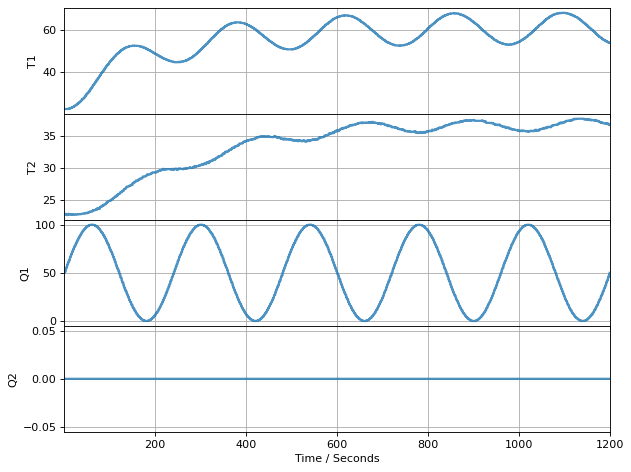

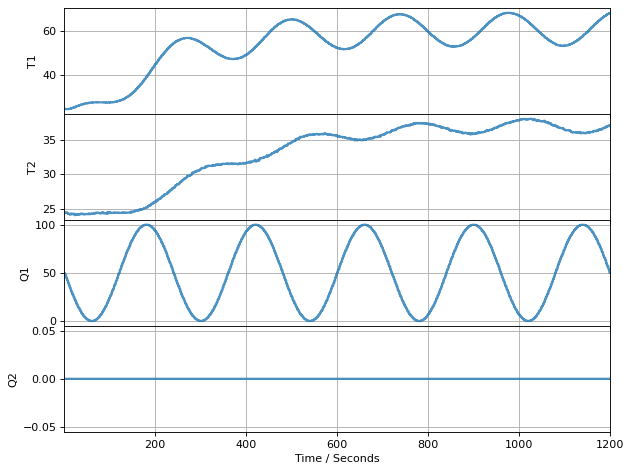

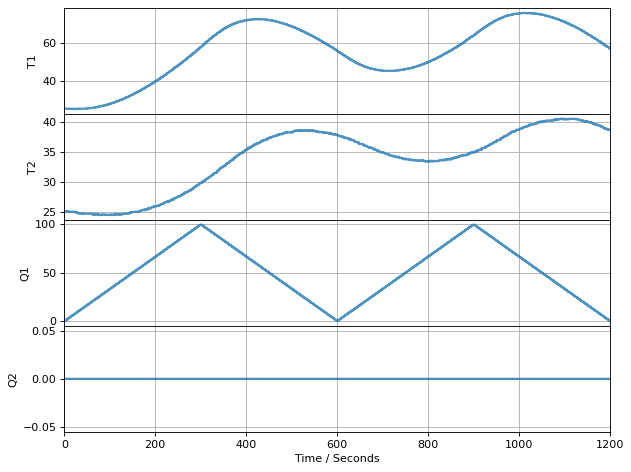

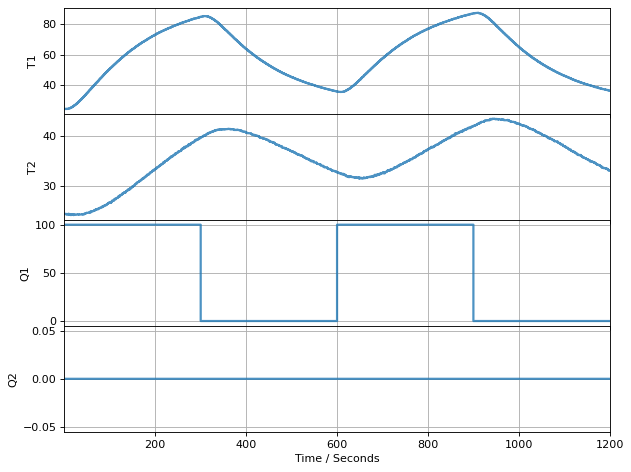

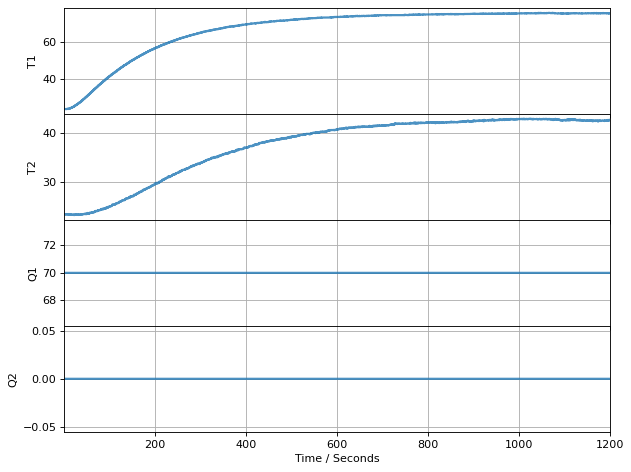

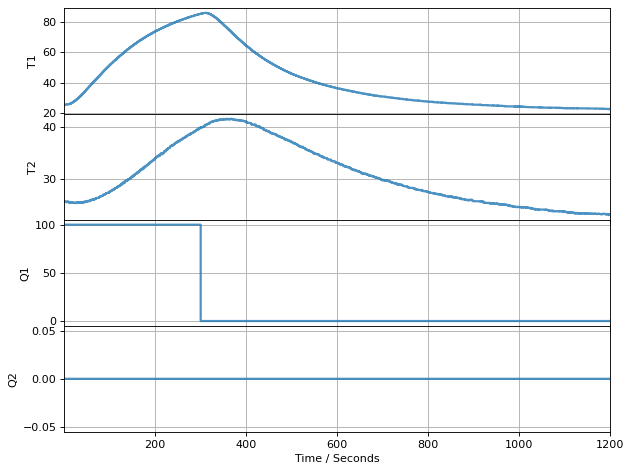

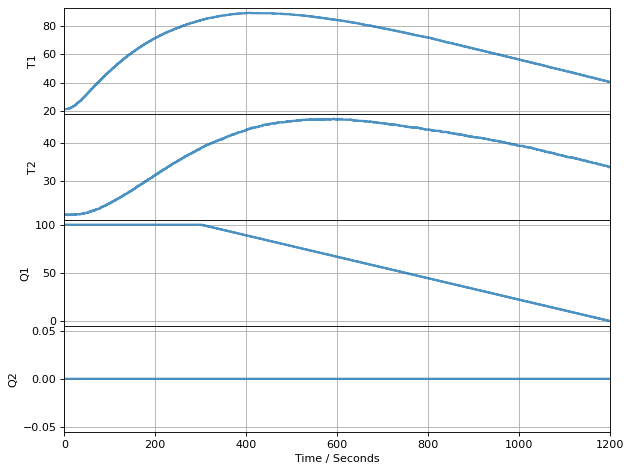

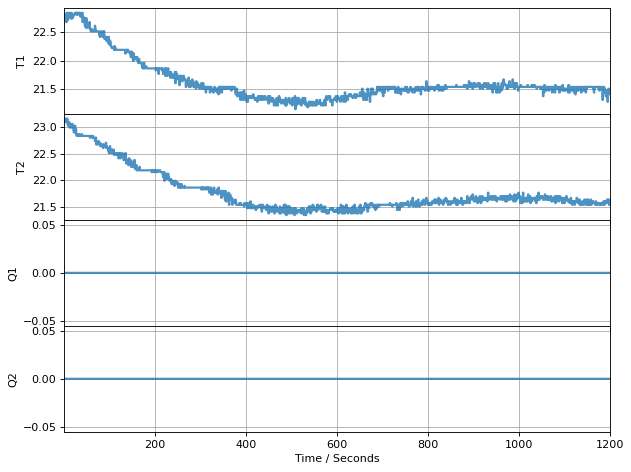

In [5]:
# Run cell to collect data for given night 1-4. Each night run takes 8 hours.
Data_Collection(Night_Number = 4)

### Plotting

In [12]:
# Plot settings for "publication quality" plots as defined in class
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=3)

plt.rcdefaults()

In [34]:
# Return to plot defaults.
plt.rcdefaults()

In [ ]:
# Plotting results of all data files
# Directory containing the CSV files
directory = os.getcwd()  # Uses current working directory

# List all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith(".csv")]
# Define variables
color_ = ['blue', 'orange', 'green', 'red']
data = ['T1','Q1','T2','Q2']

# Loop through each file
for file in csv_files:
    # Read the file and define time step
    df = pd.read_csv(os.path.join(directory, file))
    time_steps = np.arange(len(df.T1))
    print(file)

    # Loop through each column
    for i in range(len(data)):
        # Create figure
        plt.figure(figsize=(12,7))
        # Create subplot 
        plt.subplot(5,1,1)
        # Plot each column
        plt.plot(time_steps, df[data[i]],color=color_[i],label=data[i])
        plt.legend(loc='best')
        plt.grid()
        # Show plot
        plt.show()
    print('------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------')

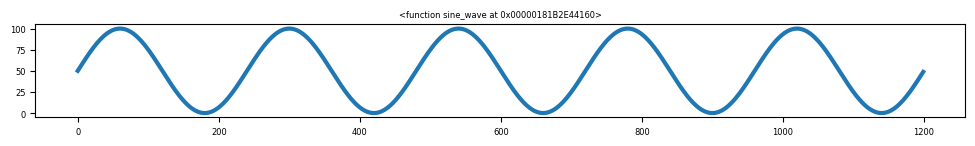

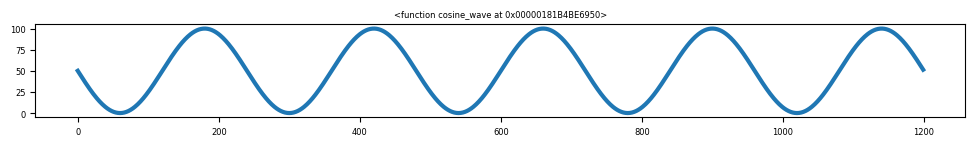

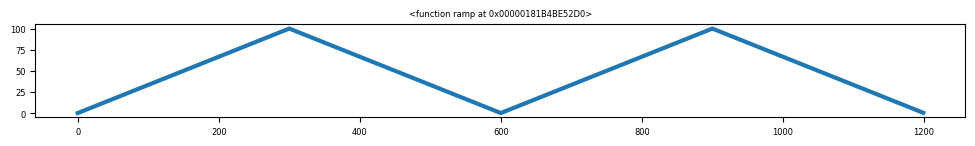

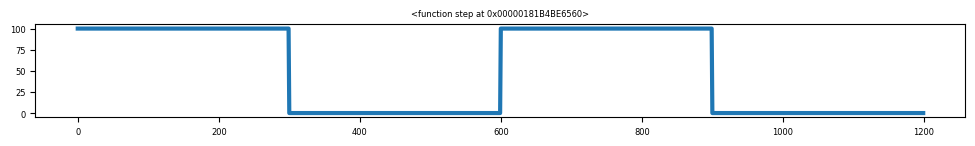

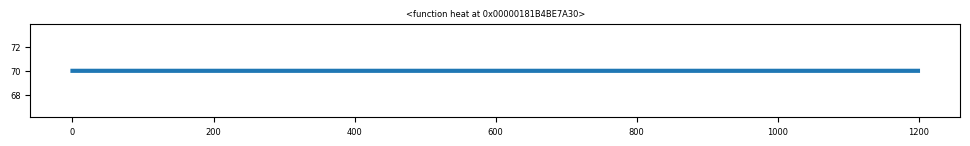

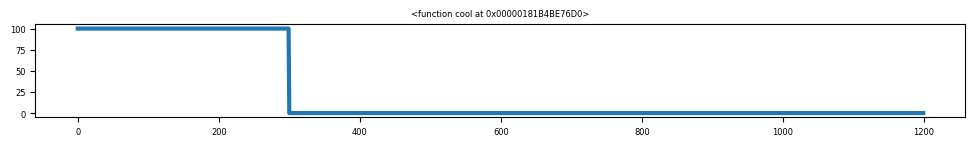

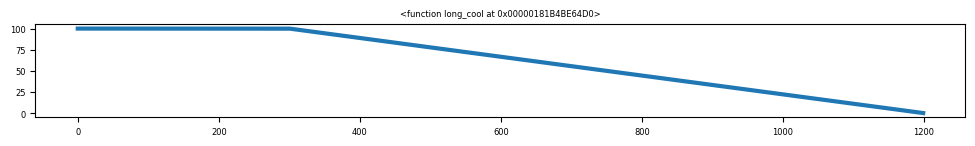

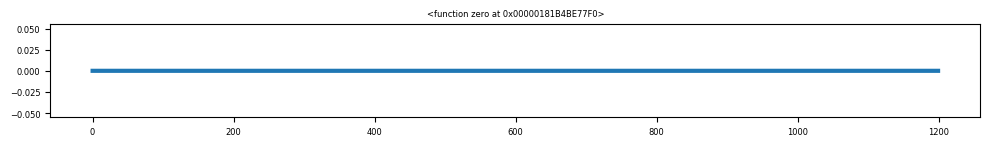

In [37]:
# Plotting heater functions for visualizations

# Define function array
functions = [sine_wave, cosine_wave, ramp, step, heat, cool, long_cool, zero]

# Loop through functions
for j in range(len(functions)):
    
    # Define time range
    t = np.arange(0,1200)
    function = []
    
    # Loop through time to create array of heater values
    for i in range(1200):
        function.append(functions[j](i))
    
    # Plot heater values
    plt.figure(figsize=(12,7))
    plt.subplot(5,1,1)
    plt.plot(t, function)
    plt.title(f"{functions[j]}")
    plt.show()

# 2. Data Processing and Creating the Model

Author: Carl Knable and Jason Rabinowitz

In this section, we interpolate the data files in order to remove any occasional gaps and ensure a constant time step of 1 second. Afterwards the data files are shuffled and merged into a single CSV, to then split into a training and validation set. The model is then created and trained using the tensorflow library.

In [2]:
# Merging and shuffling data files
def merge_and_shuffle(overwrite = False):
    ''' Merges all CSV files into one master file, shuffling the order for training.
    
    Arguments
    overwrite: boolean
    '''
    if overwrite = True:
        # Directory containing the CSV files 
        directory = os.getcwd()  # Uses current working directory
        
        # List all CSV files in the directory
        csv_files = [file for file in os.listdir(directory) if file.endswith(".csv")]
        
        # Shuffle files for training
        random.shuffle(csv_files)
        
        # Initialize an empty list to store dataframes
        dataframes = []
        
        # Read and append each CSV file
        for file in csv_files:
            df = pd.read_csv(os.path.join(directory, file))
            dataframes.append(df)
        
        # Concatenate all dataframes
        merged_df = pd.concat(dataframes, ignore_index=True)
        
        # Save the merged dataframe to a new CSV file
        output_file = "merged_output.csv"
        merged_df.to_csv(output_file, index=False)
        
        print(f"Merged {len(csv_files)} files into {output_file}")
merge_and_shuffle(overwrite = False)

Merged 76 files into merged_output.csv


In [2]:
# Preprocessing Data
# Load dataset
df = pd.read_csv("merged_output.csv")

# Extract features (Heater 1, Heater 2, Temp 1, Temp 2)
data = df[["Q1", "Q2", "T1", "T2"]].values

# Define window length
input_steps = 10   # Number of past time steps (X)
output_steps = 1   # Number of future time steps (Y)

X, Y = [], []

# Create data window 
for i in range(len(data) - input_steps - output_steps):
    X.append(data[i : i + input_steps])  # Past 10 steps
    Y.append(data[i + input_steps : i + input_steps + output_steps, 2:])  # Next 1 Temp value (T1, T2)

# Convert lists to numpy arrays
X = np.array(X)  # Shape: (samples, 10, 4)
Y = np.array(Y)  # Shape: (samples, 1, 2)

# Split into training and validation sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

# Print shape of training and validation data
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

X_train shape: (67748, 10, 4), Y_train shape: (67748, 1, 2)
X_val shape: (16937, 10, 4), Y_val shape: (16937, 1, 2)


In [ ]:
# Creating and training the model
# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(10, 4)),  # First LSTM layer
    LSTM(64),  # Second LSTM layer
    Dense(2),  # Output layer (2 values)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, Y_train, epochs=25, batch_size=32, validation_data=(X_val, Y_val))

# Save the model
model.save("tclab_lstm_model.h5")

# 3. LSTM-NN Model Evaluation

Author: Carl Knable

This section contains various analyses of the validation. The model is run on the validation set, and the error is calculated.

### Analyze All Validation Data

In [40]:
# Evaluating Validation Data
# Load the trained model
model = load_model("tclab_lstm_model.h5", custom_objects={'mse': MeanSquaredError()})

# Initialize lists to store actual and predicted values
actual_t1, actual_t2 = [], []
predicted_t1, predicted_t2 = [], []

# Loop through all validation samples
for i in tqdm(range(len(X_val)), desc="Processing Samples", unit="sample"):
    sample_input = X_val[i].reshape(1, 10, 4)  # For model input
    true_output = Y_val[i]  # Actual future temperatures
    predicted_output = model.predict(sample_input, verbose=0).reshape(1, 2)  # Predict & reshape

    # Store results
    actual_t1.extend(true_output[:, 0])  # Actual Temp 1
    actual_t2.extend(true_output[:, 1])  # Actual Temp 2
    predicted_t1.extend(predicted_output[:, 0])  # Predicted Temp 1
    predicted_t2.extend(predicted_output[:, 1])  # Predicted Temp 2

Processing Samples: 100%|████████████████████████████████████████████████████| 16937/16937 [24:38<00:00, 11.46sample/s]


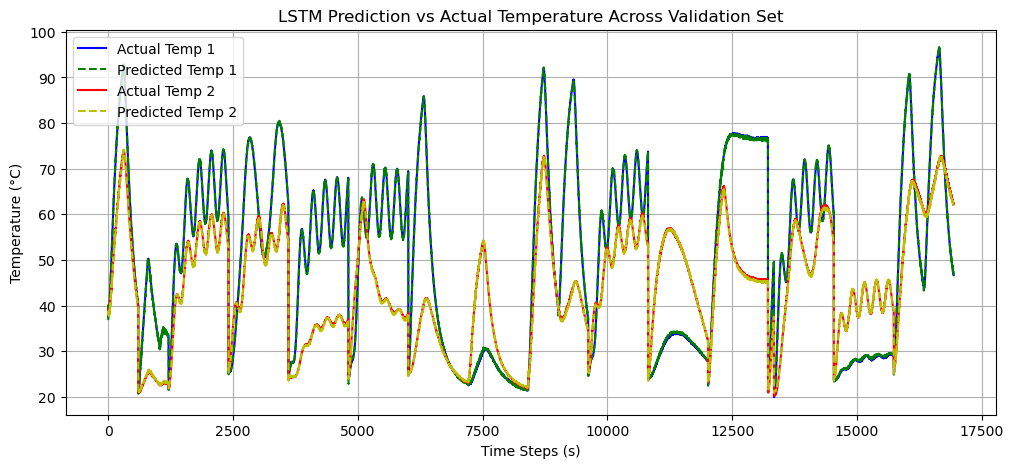

In [41]:
# Plot Validation Data
# Create a time index for plotting
time_steps = np.arange(len(actual_t1))

# Plot predictions vs actual for Temp 1
plt.figure(figsize=(12, 5))
plt.plot(time_steps, actual_t1, 'b-', label="Actual Temp 1")
plt.plot(time_steps, predicted_t1, 'g--', label="Predicted Temp 1")

# Plot predictions vs actual for Temp 2
plt.plot(time_steps, actual_t2, 'r-', label="Actual Temp 2")
plt.plot(time_steps, predicted_t2, 'y--', label="Predicted Temp 2")

plt.xlabel("Time Steps (s)")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Prediction vs Actual Temperature Across Validation Set")
plt.legend()
plt.grid()
plt.show()

In [42]:
# Calculate Error of LSTM-NN
rmse1 = np.sqrt(np.sum((np.array(actual_t1) - np.array(predicted_t1)) ** 2))
rmse2 = np.sqrt(np.sum((np.array(actual_t2) - np.array(predicted_t2)) ** 2))
print(rmse1, rmse2)

126.4004546044633 82.31154855489862


### Splitting Validation Data by Experiment to Analyze

This was done to see if the transition between experiments accounted for a significant amount of error because the model could not predict when one experiment would end and the next one began (resulting in a jump of about 20 degrees in 1 second sometimes).

[601, 1209, 2409, 3609, 4810, 6011, 9614, 10814, 12015, 13216, 13336, 14536, 15736]


Processing Samples: 100%|████████████████████████████████████████████████████████| 605/605 [00:52<00:00, 11.59sample/s]


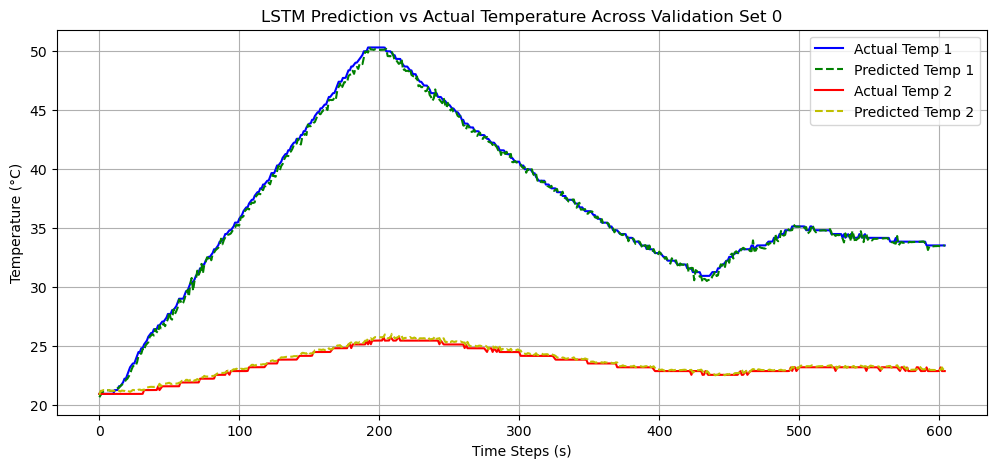

Validation Set 0: rmse1 = 6.98636153091587, rmse2 = 4.761053103153193



Processing Samples: 100%|██████████████████████████████████████████████████████| 1197/1197 [01:51<00:00, 10.73sample/s]


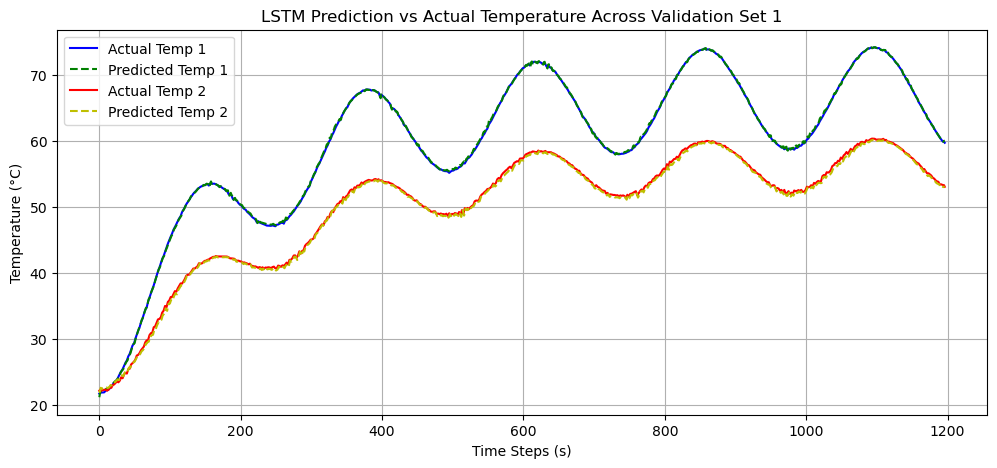

Validation Set 1: rmse1 = 5.048371786145276, rmse2 = 10.471974971867297



Processing Samples: 100%|██████████████████████████████████████████████████████| 1197/1197 [01:43<00:00, 11.58sample/s]


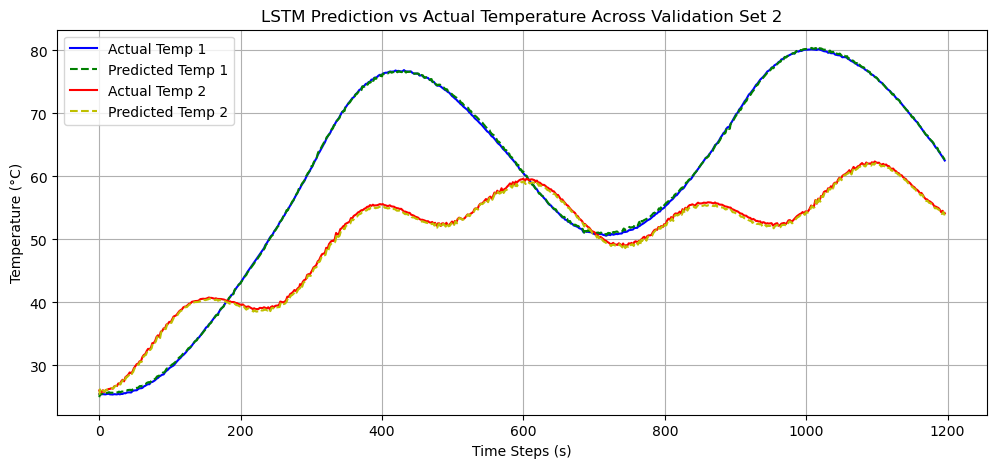

Validation Set 2: rmse1 = 7.298534074979597, rmse2 = 10.766282887156592



Processing Samples: 100%|██████████████████████████████████████████████████████| 1198/1198 [01:41<00:00, 11.80sample/s]


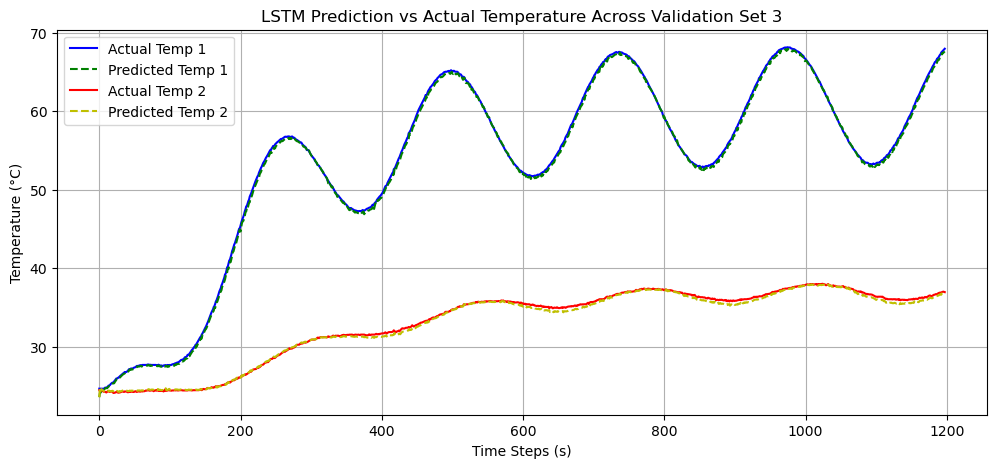

Validation Set 3: rmse1 = 10.578881970309148, rmse2 = 9.002085387102351



Processing Samples: 100%|██████████████████████████████████████████████████████| 1198/1198 [01:46<00:00, 11.25sample/s]


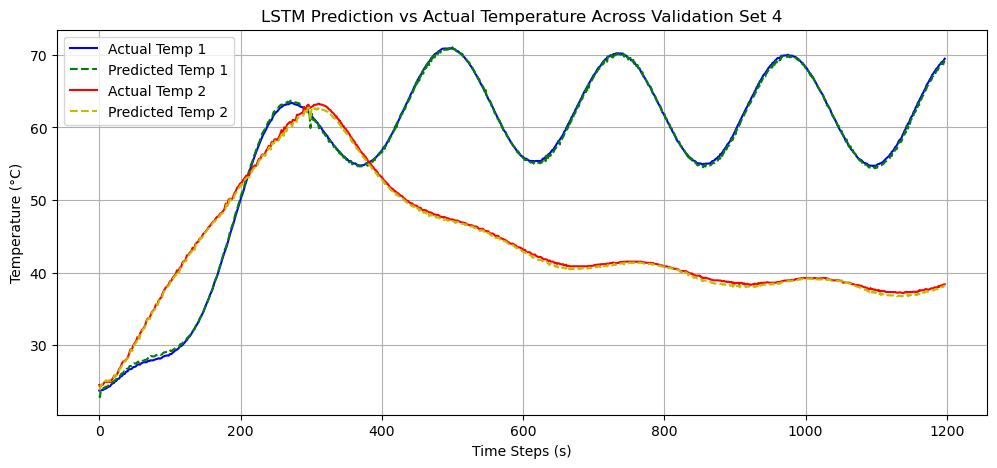

Validation Set 4: rmse1 = 9.318335612022873, rmse2 = 10.992931319038302



Processing Samples: 100%|██████████████████████████████████████████████████████| 3600/3600 [05:13<00:00, 11.49sample/s]


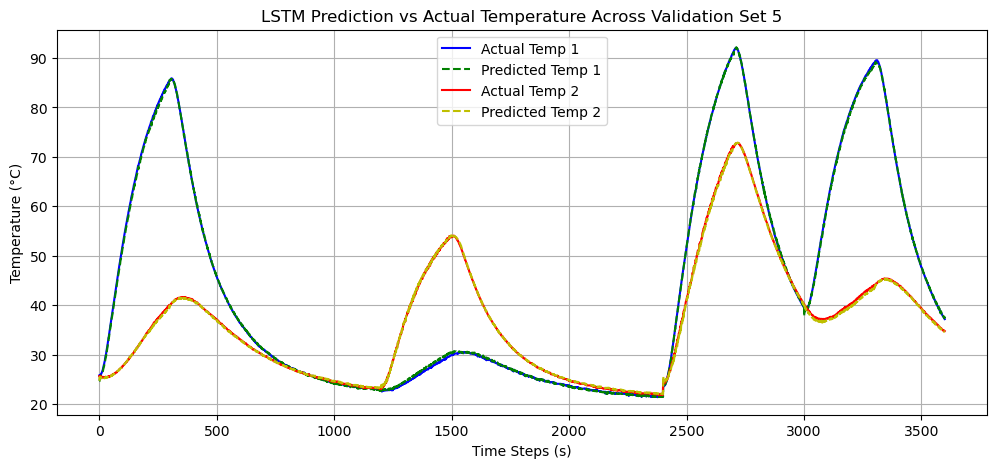

Validation Set 5: rmse1 = 17.02088441511247, rmse2 = 15.407815103874796



Processing Samples: 100%|██████████████████████████████████████████████████████| 1197/1197 [01:42<00:00, 11.70sample/s]


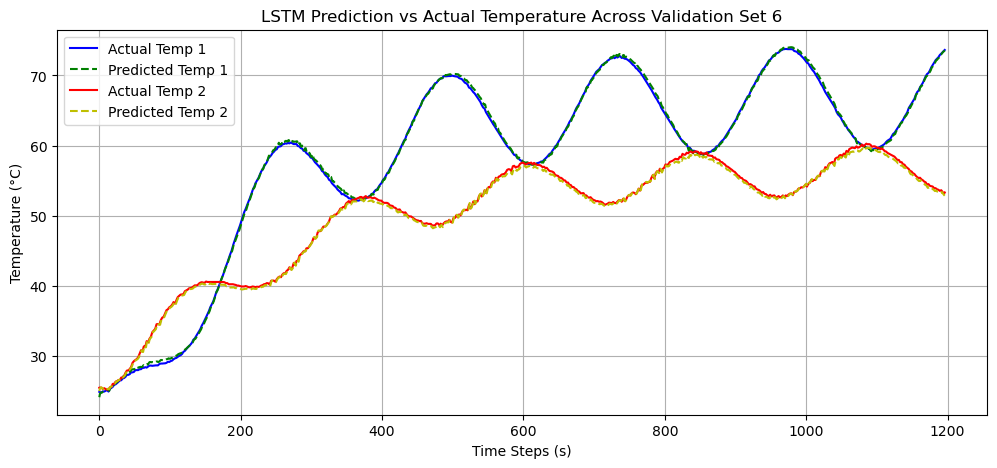

Validation Set 6: rmse1 = 9.863437310916561, rmse2 = 11.202006981604761



Processing Samples: 100%|██████████████████████████████████████████████████████| 1198/1198 [01:41<00:00, 11.86sample/s]


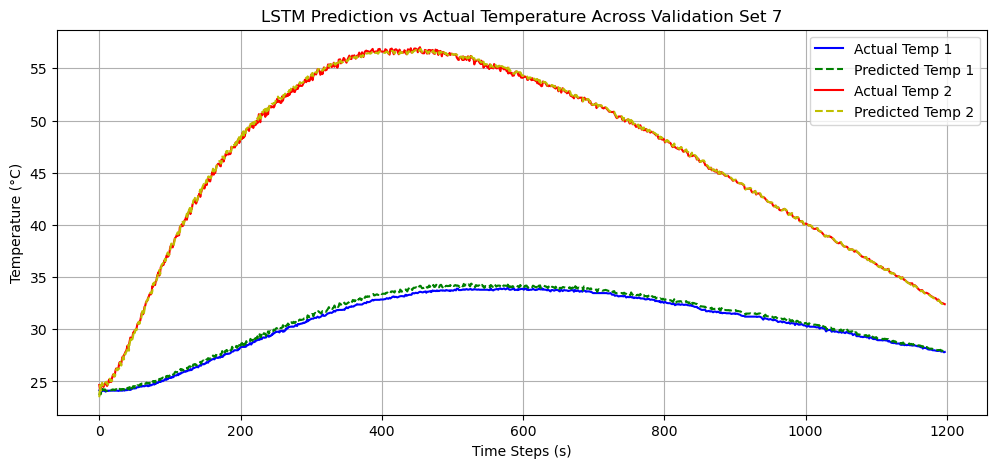

Validation Set 7: rmse1 = 11.037788122123445, rmse2 = 6.58176236552542



Processing Samples: 100%|██████████████████████████████████████████████████████| 1198/1198 [01:44<00:00, 11.47sample/s]


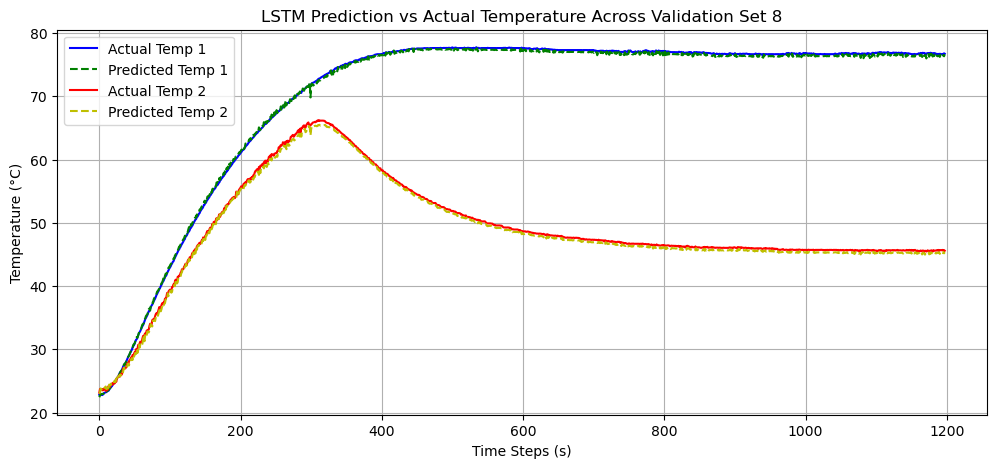

Validation Set 8: rmse1 = 10.89606136249008, rmse2 = 14.937039340920022



Processing Samples: 100%|████████████████████████████████████████████████████████| 117/117 [00:10<00:00, 11.64sample/s]


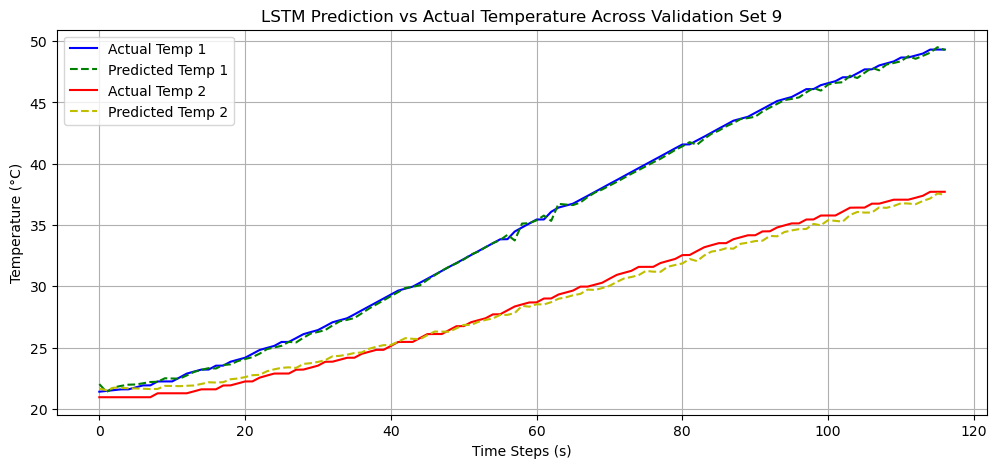

Validation Set 9: rmse1 = 2.4358980781507955, rmse2 = 5.109004428232936



Processing Samples: 100%|██████████████████████████████████████████████████████| 1197/1197 [01:45<00:00, 11.36sample/s]


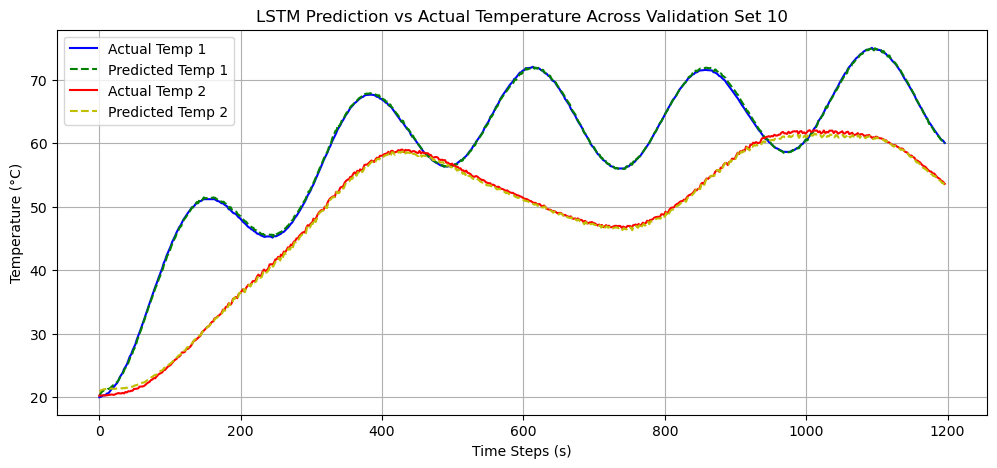

Validation Set 10: rmse1 = 7.843389811153463, rmse2 = 13.11680160224994



Processing Samples: 100%|██████████████████████████████████████████████████████| 1197/1197 [01:44<00:00, 11.46sample/s]


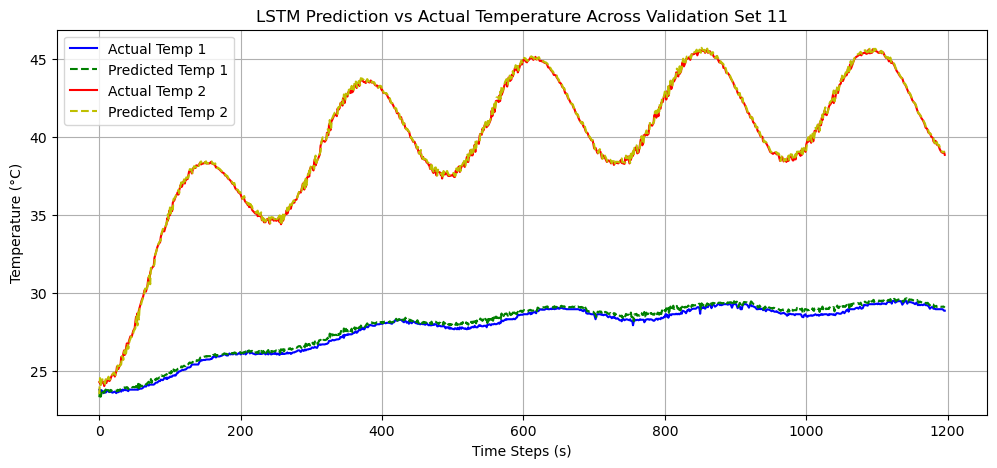

Validation Set 11: rmse1 = 8.356112928237003, rmse2 = 6.149752305953881



In [49]:
# Dividing By Experiment, Predicting, Plotting, and Calculating Error
# See where one run stops and the next one begins
dif_run_index = []
for i in range(len(Y_val)-1):
    if Y_val[i,0,0]-Y_val[i+1,0,0] > 1:
        dif_run_index.append(i)
print(dif_run_index)

# Load the trained model
model = load_model("tclab_lstm_model.h5", custom_objects={'mse': MeanSquaredError()})

rmse1_NN = []

pred_t1_all = []

# Loop through all validation samples
for j in range(len(dif_run_index)-1):
    X_val_i = X_val[dif_run_index[j]+3:dif_run_index[j+1]]
    Y_val_i = Y_val[dif_run_index[j]+3:dif_run_index[j+1]]

    # Initialize lists to store actual and predicted values
    actual_t1_a, actual_t2_a = [], []
    predicted_t1_a, predicted_t2_a = [], []
    
    for i in tqdm(range(len(X_val_i)), desc="Processing Samples", unit="sample"):
        sample_input = X_val_i[i].reshape(1, 10, 4)  # For model input
        true_output = Y_val_i[i]  # Actual future temperatures
        predicted_output = model.predict(sample_input, verbose=0).reshape(1, 2)  # Predict & reshape
    
        # Store results
        actual_t1_a.extend(true_output[:, 0])  # Actual Temp 1
        actual_t2_a.extend(true_output[:, 1])  # Actual Temp 2
        predicted_t1_a.extend(predicted_output[:, 0])  # Predicted Temp 1
        predicted_t2_a.extend(predicted_output[:, 1])  # Predicted Temp 2

    # Plot Validation Data
    # Create a time index for plotting
    time_steps = np.arange(len(actual_t1_a))
    
    # Plot predictions vs actual for Temp 1
    plt.figure(figsize=(12, 5))
    plt.plot(time_steps, actual_t1_a, 'b-', label="Actual Temp 1")
    plt.plot(time_steps, predicted_t1_a, 'g--', label="Predicted Temp 1")
    
    # Plot predictions vs actual for Temp 2
    plt.plot(time_steps, actual_t2_a, 'r-', label="Actual Temp 2")
    plt.plot(time_steps, predicted_t2_a, 'y--', label="Predicted Temp 2")
    
    plt.xlabel("Time Steps (s)")
    plt.ylabel("Temperature (°C)")
    plt.title(f"LSTM Prediction vs Actual Temperature Across Validation Set {j}")
    plt.legend()
    plt.grid()
    plt.show()

    pred_t1_all.append(predicted_t1_a)
    
    # Calculate Error of LSTM-NN
    rmse1 = np.sqrt(np.sum((np.array(actual_t1_a) - np.array(predicted_t1_a)) ** 2))
    rmse2 = np.sqrt(np.sum((np.array(actual_t2_a) - np.array(predicted_t2_a)) ** 2))
    rmse1_NN.append(rmse1)
    print(f"Validation Set {j}: rmse1 = {rmse1}, rmse2 = {rmse2}")
    print()

# 4. ODE Class Model Evaluation and Comparison

Author: Carl Knable

In this section we take code from class and evaluate the validation data using the ODE, and compare it to the validation data for the LSTM-NN.

### Analyze All Validation Data

In [33]:
# Define the ODE
# parameters
T_amb = 21  # deg C
alpha = 0.00016  # watts / (units P1 * percent U1)
P1 = 100  # P1 units
U1 = 50  # steady state value of u1 (percent)
P2 = 100
dt = 1
verbose = False
# fitted model parameters
# adjust using your values from Lab 2
Ua = 0.044  # watts/deg C
Ub = 0.036  # watts/deg C
Uc = 0
CpH = 2.274  # joules/deg C
CpS = 2.929 # joules/deg C

# Hint: You need to define the system matrices A, B, C, and D    
# Assume the state vector is x = [T1H, T1S, T2H, T2S]
# Assume the input vector is u = [Q1, Q2]
# Add your solution here
A = np.array([[-(Ua+Uc+Ub)/CpH, Ub/CpH, Uc/CpH, 0],
     [Ub/CpS, -Ub/CpS, 0, 0],
     [Uc/CpH, 0, -(Ua+Uc+Ub)/CpH, Ub/CpH],
     [0, 0, Ub/CpH, -Ub/CpH]])

B = np.array([[alpha*P1/CpH,0],
     [0,0],
     [0,alpha*P2/CpH],
     [0,0]])

C = np.array([
    [0, 1, 0, 0],  # T1S output
    [0, 0, 0, 1]   # T2S output
])

D = np.zeros((2, 2))  # no feedthrough

'''
C = np.array([[1,0], #[0,1]
     [0,1]])

D = np.array([0])
'''

if verbose:
    # Print the matrices
    print("Matrix A:\n", A)
    print("\nMatrix B:\n", B)
    print("\nMatrix C:\n", C)
    print("\nMatrix D:\n", D)

# Convert A and B matrices to discrete time using zero-order hold
# Zero-order hold: assumes input is constant during time interval
# This is a reasonable assumption for our system
from scipy.signal import cont2discrete

d_system = cont2discrete((A, B, C, D), dt, method='zoh')

# Extract the discrete time A and B matrices
Ad = d_system[0]
Bd = d_system[1]
Cd = d_system[2]
Dd = d_system[3]

In [34]:
# Define simulation function for the ODE
def simulate_state_space_model(U_input, x0, A, B, C, D):
    """
    Simulate a MIMO (multi-input, multi-output) discrete-time state-space model.

    Parameters:
        U_input: list or array of input vectors u_k (each u_k is a 1D array of shape (2,))
        x0: initial state vector (e.g., [T1H, T1S, T2H, T2S])
        A, B, C, D: state-space matrices

    Returns:
        Y: array of predicted output vectors y_k (e.g., [[T1S_k, T2S_k], ...])
    """
    x = x0
    outputs = []

    for u in U_input:
        u = np.array(u).reshape(-1, 1)  # ensure shape (2, 1)
        y = C @ x + D @ u              # output shape (2, 1)
        outputs.append(y.flatten())    # flatten to (2,)
        x = A @ x + B @ u              # next state

    return np.array(outputs)  # shape: (timesteps, 2)


In [45]:
# Simulate the ODE
ode_preds = []
for i in tqdm(range(len(X_val)), desc="Descriptive ODE T1+T2"):
    sequence = X_val[i]                   # (10, 4)

    # Use current heater inputs at t=0
    Q_now = sequence[-1, 0:2]             # [Q1, Q2] → shape: (2,)
    Q_future = [Q_now]                   # single step input

    # Last known temps
    T1S_0 = sequence[-1, 2]
    T2S_0 = sequence[-1, 3]

    # Initial state: assume heater blocks start at 0°C (or tweak if you have estimates)
    x0 = np.array([0.0, T1S_0, 0.0, T2S_0])

    pred = simulate_state_space_model(Q_future, x0, Ad, Bd, Cd, Dd)  # shape: (1, 2)
    ode_preds.append(pred[0])  # store [T1S, T2S] prediction




Descriptive ODE T1+T2: 100%|██████████████████████████████████████████████████| 16937/16937 [00:00<00:00, 38350.97it/s]


In [ ]:
# Plot ODE Prediction
# Convert to numpy array and flatten for comparison
ode_preds = np.array(ode_preds)        # shape: (num_samples, 5)
ode_flat = ode_preds.flatten()         # shape: (num_samples * 5,)

# Extract relevant data (no flattening needed)
true_t1 = Y_val[:, 0, 0]
true_t2 = Y_val[:, 0, 1]
nn_t1 = predicted_t1
nn_t2 = predicted_t2
ode_t1 = ode_preds[:, 0]  # Already 1-step ODE prediction for T1

# Plot T1 Comparison
plt.figure(figsize=(10, 4))
plt.plot(true_t1, 'b-', label="True T1")
plt.plot(nn_t1, 'g--', label="NN T1")
plt.plot(ode_t1, 'r:', label="ODE T1")
plt.legend()
plt.title("T1 Model Predictions Across Validation Set")
plt.xlabel("Time Steps (s)")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.tight_layout()
plt.show()


In [38]:
# Calculate ODE Error
rmse1 = np.sqrt(np.sum((np.array(actual_t1) - np.array(ode_t1)) ** 2))
print(rmse1)

3.8704019171140343


### Splitting Validation Data by Experiment to Analyze

Descriptive ODE T1+T2: 100%|██████████████████████████████████████████████████████| 605/605 [00:00<00:00, 26422.67it/s]


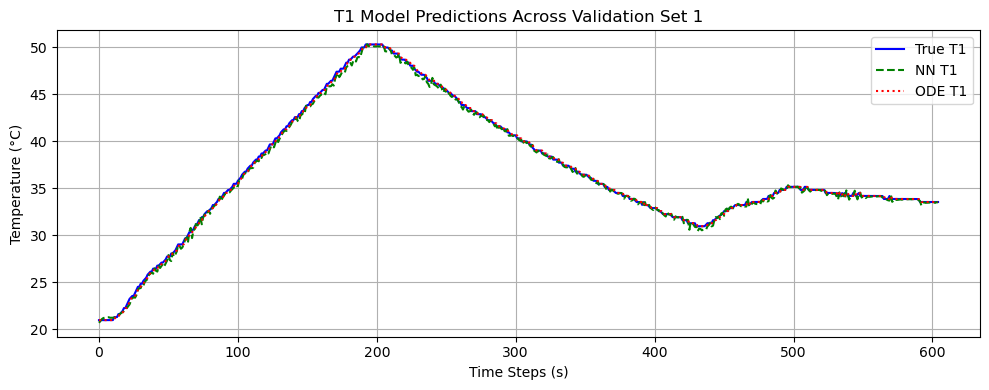

Validation Set 0: rmse1 = 3.8704019171140343



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 39833.56it/s]


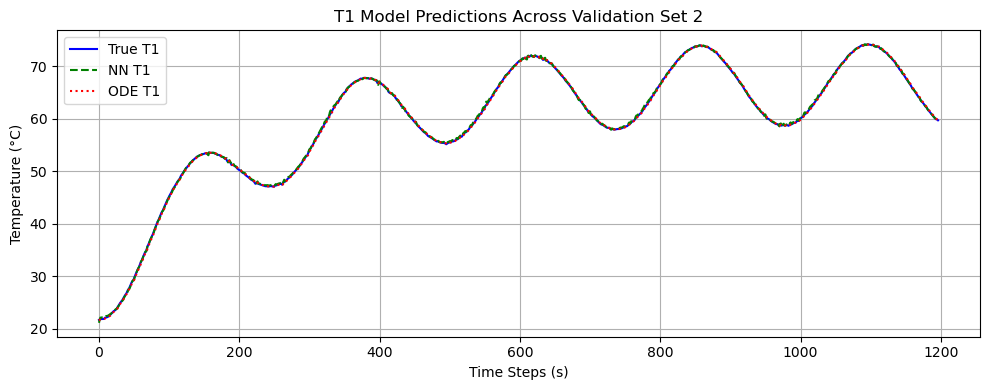

Validation Set 1: rmse1 = 5.6223009524571



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 37203.55it/s]


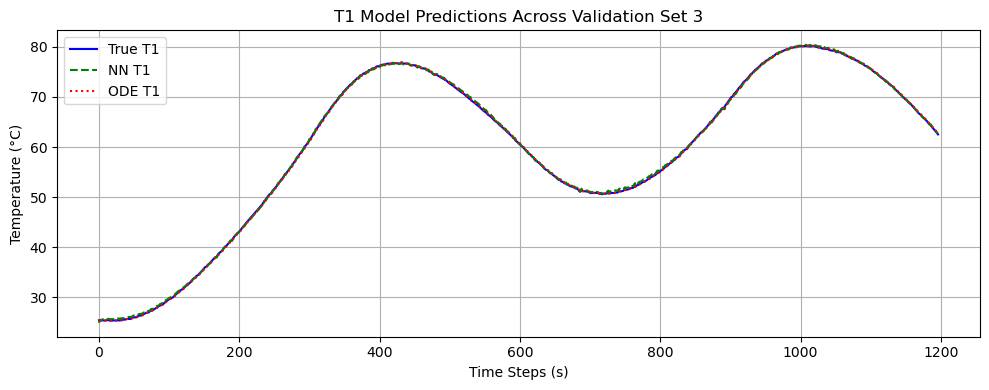

Validation Set 2: rmse1 = 4.341181636375056



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1198/1198 [00:00<00:00, 32456.23it/s]


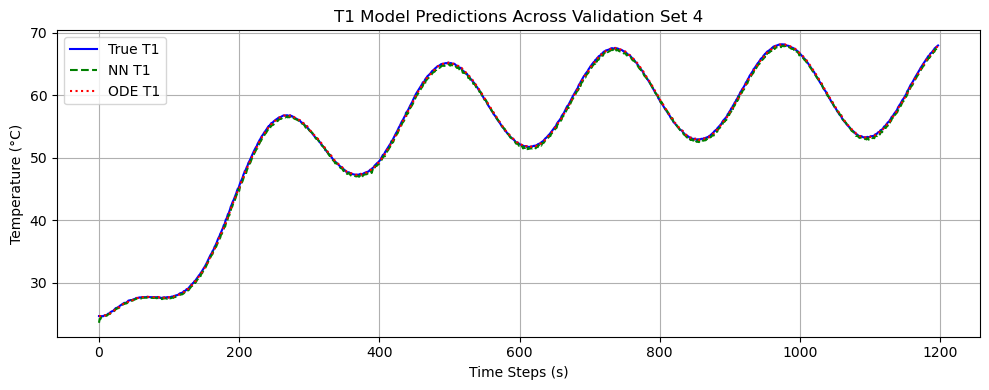

Validation Set 3: rmse1 = 5.306207402655875



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1198/1198 [00:00<00:00, 31754.55it/s]


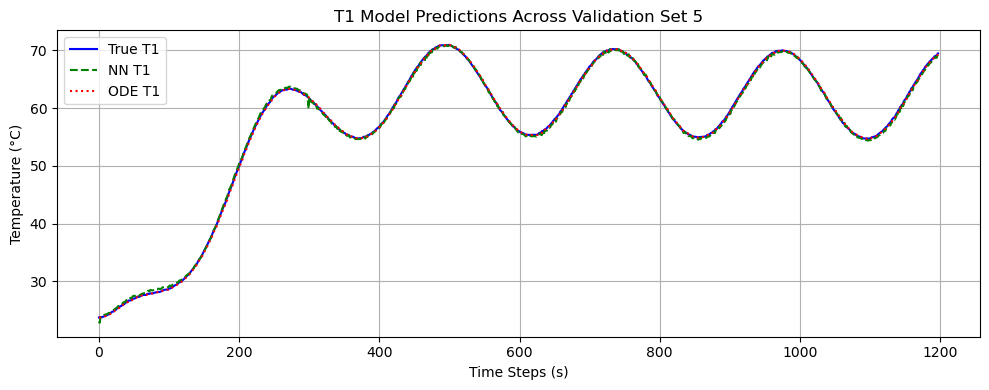

Validation Set 4: rmse1 = 5.554743288397761



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 3600/3600 [00:00<00:00, 33020.53it/s]


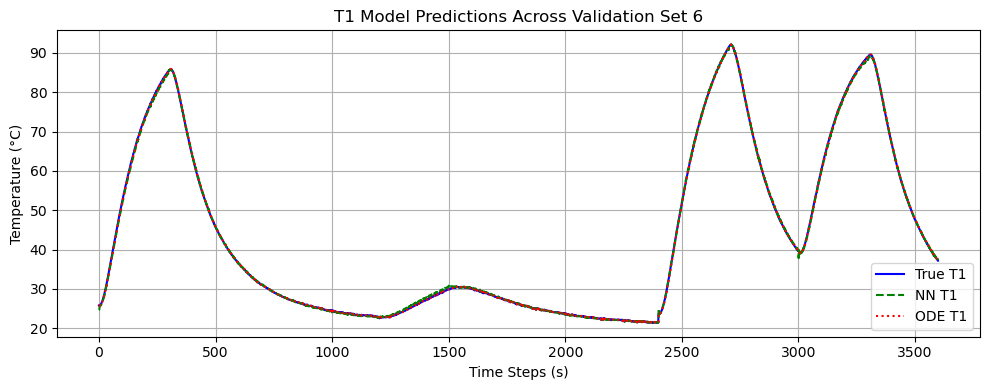

Validation Set 5: rmse1 = 10.098171220572562



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 34955.45it/s]


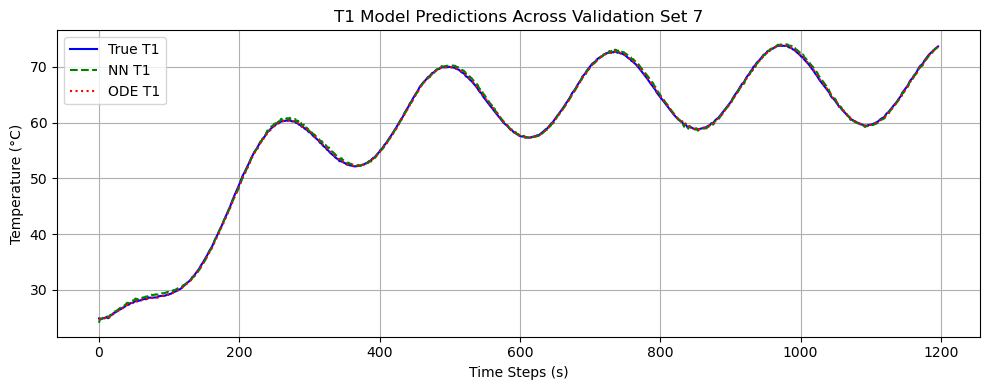

Validation Set 6: rmse1 = 5.0897723917676325



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1198/1198 [00:00<00:00, 39211.95it/s]


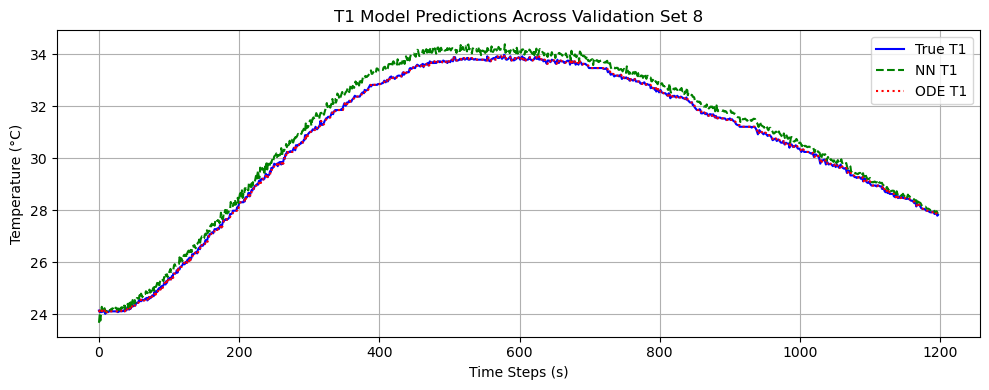

Validation Set 7: rmse1 = 1.728374380740471



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1198/1198 [00:00<00:00, 39771.54it/s]


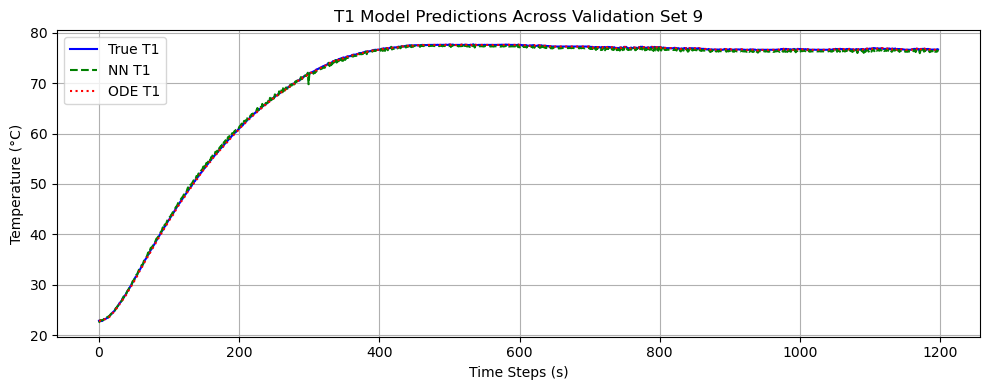

Validation Set 8: rmse1 = 3.905617108729411



Descriptive ODE T1+T2: 100%|██████████████████████████████████████████████████████| 117/117 [00:00<00:00, 38987.33it/s]


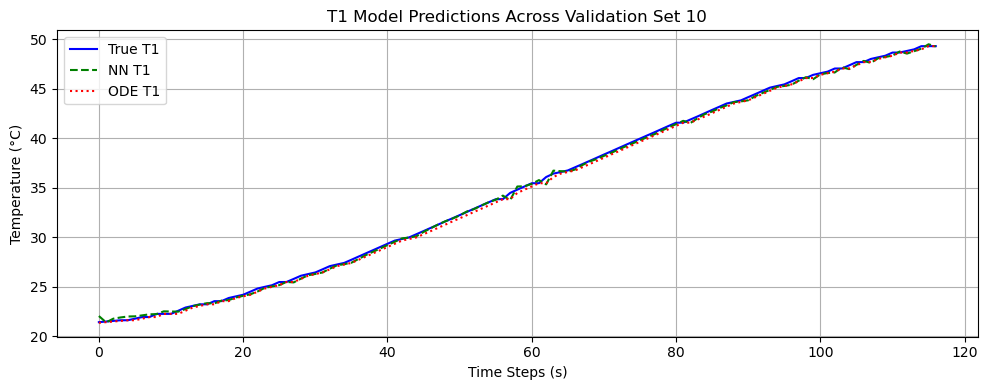

Validation Set 9: rmse1 = 2.9334624592791374



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 33668.52it/s]


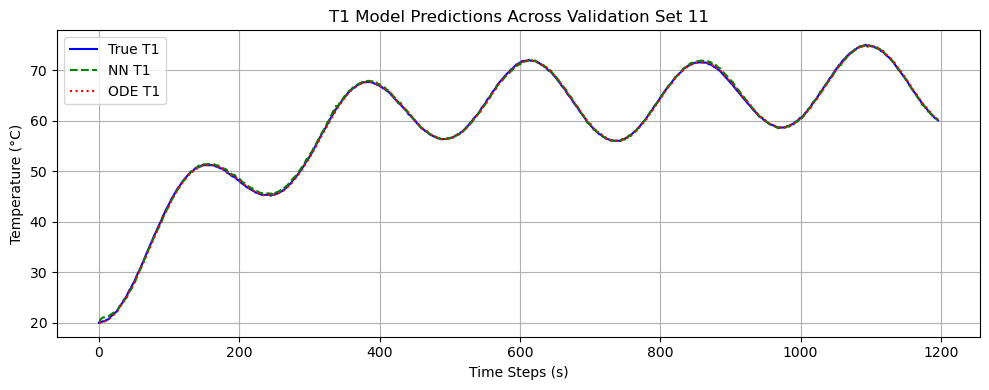

Validation Set 10: rmse1 = 5.511612558952234



Descriptive ODE T1+T2: 100%|████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 36022.63it/s]


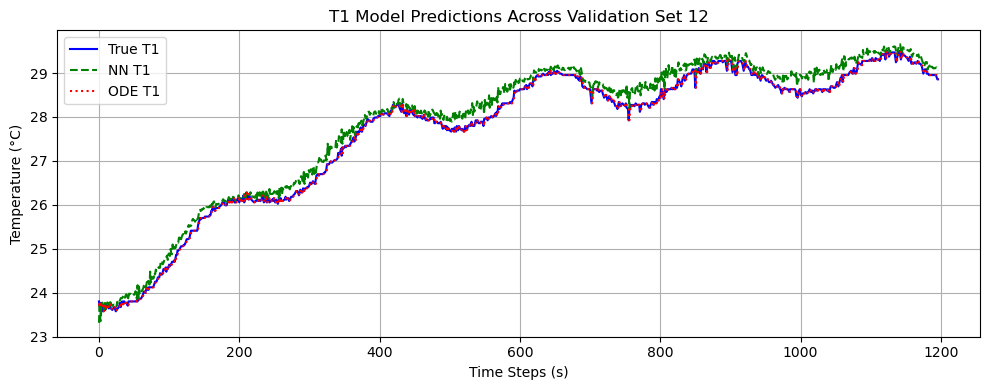

Validation Set 11: rmse1 = 1.8445655315005747



In [70]:
# Dividing By Experiment, Predicting, Plotting, and Calculating Error
# Loop through all validation samples
rmse1_ODE = []
for j in range(len(dif_run_index)-1):
    X_val_i = X_val[dif_run_index[j]+3:dif_run_index[j+1]]
    Y_val_i = Y_val[dif_run_index[j]+3:dif_run_index[j+1]]

    # Initialize lists to store actual and predicted values
    ode_preds = []
    
    for i in tqdm(range(len(X_val_i)), desc="Descriptive ODE T1+T2"):
        sequence = X_val_i[i]                   # (10, 4)
    
        # Use current heater inputs at t=0
        Q_now = sequence[-1, 0:2]             # [Q1, Q2] → shape: (2,)
        Q_future = [Q_now]                   # single step input
    
        # Last known temps
        T1S_0 = sequence[-1, 2]
        T2S_0 = sequence[-1, 3]
    
        # Initial state: assume heater blocks start at 0°C (or tweak if you have estimates)
        x0 = np.array([0.0, T1S_0, 0.0, T2S_0])
    
        pred = simulate_state_space_model(Q_future, x0, Ad, Bd, Cd, Dd)  # shape: (1, 2)
        ode_preds.append(pred[0])  # store [T1S, T2S] prediction
    # Convert to numpy array and flatten for comparison
    ode_preds = np.array(ode_preds)        # shape: (num_samples, 5)
    ode_flat = ode_preds.flatten()         # shape: (num_samples * 5,)
    
    # Extract relevant data (no flattening needed)
    true_t1 = Y_val_i[:, 0, 0]
    nn_t1 = pred_t1_all[j]
    ode_t1 = ode_preds[:, 0]  # Already 1-step ODE prediction for T1
    
    # Plot T1 Comparison
    plt.figure(figsize=(10, 4))
    plt.plot(true_t1, 'b-', label="True T1")
    plt.plot(nn_t1, 'g--', label="NN T1")
    plt.plot(ode_t1, 'r:', label="ODE T1")
    plt.legend()
    plt.title(f"T1 Model Predictions Across Validation Set {j+1}")
    plt.xlabel("Time Steps (s)")
    plt.ylabel("Temperature (°C)")
    plt.grid()
    plt.tight_layout()
    plt.show()
    rmse1 = np.sqrt(np.sum((np.array(true_t1) - np.array(ode_t1)) ** 2))
    print(f"Validation Set {j}: rmse1 = {rmse1}")
    print()
    rmse1_ODE.append(rmse1)

### Comparing the NN and ODE Error

In [66]:
# Comparing the RMSE for T1 in the NN vs ODE 
print('Set   NN  , ODE')
for i in range(len(rmse1_NN)):
    print(i+1,' ',np.round(np.array(rmse1_NN),2)[i],',',np.round(np.array(rmse1_ODE),2)[i])

Set   NN  , ODE
1   6.99 , 3.87
2   5.05 , 5.62
3   7.3 , 4.34
4   10.58 , 5.31
5   9.32 , 5.55
6   17.02 , 10.1
7   9.86 , 5.09
8   11.04 , 1.73
9   10.9 , 3.91
10   2.44 , 2.93
11   7.84 , 5.51
12   8.36 , 1.84


# 5. TC Lab Implementation

Author: Jason Rabinowitz

In this section the model is implemented using open loop optimization and run on the TC-Lab.

In [ ]:
# Ambient temperature test
# experimental parameters
tfinal = 30

# To complete the experiment, change this to True
# After completing the experiment, be sure to change it back to False
# This will prevent you from overwriting your data
run_tamb_tclab = False

from tclab import TCLab, clock, Historian, Plotter, setup
import numpy as np

if run_tamb_tclab:

    lab_device = setup(connected=True)

    # initialize list to store temperature
    T_list = []

    # perform experiment
    with lab_device() as lab:
        lab.U1 = 0
        lab.U2 = 0
        h = Historian(lab.sources)
        p = Plotter(h, tfinal)
        
        # save temperatures to access later
        T_list.append(lab.T1)
        T_list.append(lab.T2)

        for t in clock(tfinal):
            p.update(t)

        # estimate ambient temperature
        Tamb = np.mean(T_list) # deg C
        print(f"The ambient temperature is {Tamb} degrees C")

In [ ]:
# Define functions
# User settings
dt          = 1.0
total_time  = 200.0
window      = 15
n_blocks    = 50
w1, w2      = 1.0, 1.0

popsize  = 15
max_iter = 30
dim         = 2 * n_blocks
bounds      = [(0,100)] * dim
population   = popsize * dim
total_evals  = (max_iter + 1) * population
tol          = 0.03

# Define set point functions
def SP1(t):
    t = np.asarray(t)
    return np.where(t <= 150, 25 + (40 - 25) * (t / 150), 40)

def SP2(t):
    t = np.asarray(t)
    return np.where(t <= 150, 24.5 + (35 - 24.5) * (t / 150), 35)

# Load model
model = load_model('tclab_lstm_model_raw.keras')

# Helper: blocks -> full control sequence
def blocks_to_sequence(x):
    N = int(total_time / dt)
    bl = N // n_blocks
    u1_b, u2_b = x[:n_blocks], x[n_blocks:]
    u1_seq = np.repeat(u1_b, bl)[:N]
    u2_seq = np.repeat(u2_b, bl)[:N]
    return u1_seq, u2_seq

# Cost function 
def open_loop_cost_batched(x, init_hist, model, dt, total_time, window, SP1, SP2, w1, w2, blocks_to_sequence, overshoot_weight=5.0):
    """
    Batch all LSTM calls into a single predict call per cost evaluation.
    Adds overshoot penalties for T1 and T2 above SP1 and SP2 respectively.
    """
    u1_seq, u2_seq = blocks_to_sequence(x)
    N = int(total_time / dt)

    hist = deque(init_hist, maxlen=window)
    X_batch = np.zeros((N, window, 4))
    t_vals = np.zeros(N)

    for i, (u1, u2) in enumerate(zip(u1_seq, u2_seq)):
        H = np.array(hist)
        tail = H[1:, :]
        last_T1, last_T2 = H[-1, 2], H[-1, 3]
        X_batch[i] = np.vstack([tail, [u1, u2, last_T1, last_T2]])
        t_vals[i] = (i + 1) * dt
        hist.append([u1, u2, last_T1, last_T2])

    preds = model.predict(X_batch, verbose=0)
    T1_preds, T2_preds = preds[:, 0], preds[:, 1]

    # Standard squared-error cost
    SP1_vals = SP1(t_vals)
    SP2_vals = SP2(t_vals)
    err1 = T1_preds - SP1_vals
    err2 = T2_preds - SP2_vals
    cost = np.sum(w1 * err1**2 + w2 * err2**2)

    # Overshoot penalties
    overshoot1 = np.maximum(err1, 0.0)
    overshoot2 = np.maximum(err2, 0.0)
    cost += overshoot_weight * (np.sum(overshoot1**2) + np.sum(overshoot2**2))

    return cost

In [ ]:
# Stage 1: Collect history, U = 0
print("Stage 1: Collecting initial plant history…")
with TCLab() as lab:
    init_hist = deque(maxlen=window)
    for _ in clock(window * dt, dt):
        lab.U1 = lab.U2 = 0
        init_hist.append([lab.U1, lab.U2, lab.T1, lab.T2])
print("Stage 1 complete.\n")

In [ ]:
# Stage 2: Optimization
call_counter = {'n': 0}
gen_info     = {'gen': 0}

def open_loop_cost_logged(block_vars, init_history):
    call_counter['n'] += 1
    pct = call_counter['n'] / total_evals * 100
    print(f"[{time.strftime('%H:%M:%S')}] call #{call_counter['n']} ({pct:.1f}% of approx.)", flush=True)
    return open_loop_cost(block_vars, init_history)

def de_callback(xk, convergence):
    gen_info['gen'] += 1
    best_c = open_loop_cost(xk, init_hist)
    print(f"→ Generation {gen_info['gen']:2d}: best cost = {best_c:.2f}, conv = {convergence:.3f}", flush=True)
    return False

result = differential_evolution(
    open_loop_cost_logged,
    bounds,
    args=(init_hist,),
    maxiter=max_iter,
    popsize=popsize,
    callback=de_callback,
    tol=tol,
    polish=True,
    disp=True
)

opt_blocks = result.x
u1_opt, u2_opt = blocks_to_sequence(opt_blocks)

print("Optimized U1 blocks:", opt_blocks[:n_blocks], flush=True)
print("Optimized U2 blocks:", opt_blocks[n_blocks:], flush=True)
print("Final cost:", result.fun, flush=True)

In [ ]:
# Stage 3: Run with live plot
plt.ion()
time_holder = {'t': 0.0}

with TCLab() as lab:
    h = Historian([
        ('T1',  lambda: lab.T1),
        ('T2',  lambda: lab.T2),
        ('Q1',  lambda: lab.U1),
        ('Q2',  lambda: lab.U2),
        ('SP1', lambda: SP1(time_holder['t'])),
        ('SP2', lambda: SP2(time_holder['t']))
    ])
    p = Plotter(h, total_time, layout=(('T1','SP1','T2','SP2'),('Q1','Q2')))
    for t_current, u1_cmd, u2_cmd in zip(clock(total_time, dt), u1_opt, u2_opt):
        time_holder['t'] = t_current
        lab.U1, lab.U2   = u1_cmd, u2_cmd
        p.update(t_current)

In [ ]:
# Run historian with U = 100
import matplotlib.pyplot as plt
from tclab import TCLab, clock, Historian, Plotter

# Run parameters
total_time = 100    # seconds
dt         = 1.0    # control interval (s)

# Turn on interactive plotting
plt.ion()

with TCLab() as lab:
    # Record time, temps and heater outputs
    h = Historian([
        ('T1', lambda: lab.T1),
        ('T2', lambda: lab.T2),
        ('Q1', lambda: lab.U1),
        ('Q2', lambda: lab.U2)
    ])
    # Layout: first row = T1,T2; second row = Q1,Q2
    p = Plotter(h, total_time, layout=(('T1','T2'),('Q1','Q2')))

    # Main loop
    for t in clock(total_time, dt):
        lab.U1 = 100
        lab.U2 = 100
        p.update(t)

# Turn off interactive mode
plt.ioff()